In [1]:
import Scrapers.ackerman_scraper as ack_scraper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
raw = ack_scraper.dataframe_ackerman_auction()

{1185: '183 Apr 7, 2018 (NY)', 1187: '183A Apr 21, 2018 (HK)', 1188: '184 May 16, 2018 (NY)', 1190: '184A Jun 9, 2018 (HK)', 1192: '185 Jun 20, 2018 (NY)', 1184: '182A Mar 24, 2018 (HK)', 1196: '186 Sep 7, 2018 (NY)', 1197: '185A Sep 22, 2018 (HK)', 1165: '175A Sep 23, 2017 (HK)', 1168: '177 Oct 13, 2017 (NY)', 1202: '187 Oct 12, 2018 (NY)', 1172: '178 Nov 18, 2017 (NY)', 1173: '177A Dec 9, 2017 (HK)', 1174: '179 Dec 13, 2017 (NY)', 1177: '181A Jan 27, 2018 (HK)', 1179: '181 Feb 9, 2018 (NY)', 1163: '176 Sep 9, 2017 (NY)', 1181: '182 Mar 10, 2018 (NY)', 1170: '176A Nov 4, 2017 (HK)'}
1185 183 Apr 7, 2018 (NY)
1187 183A Apr 21, 2018 (HK)
1188 184 May 16, 2018 (NY)
1190 184A Jun 9, 2018 (HK)
1192 185 Jun 20, 2018 (NY)
1184 182A Mar 24, 2018 (HK)
1196 186 Sep 7, 2018 (NY)
1197 185A Sep 22, 2018 (HK)
1165 175A Sep 23, 2017 (HK)
1168 177 Oct 13, 2017 (NY)
1202 187 Oct 12, 2018 (NY)
1172 178 Nov 18, 2017 (NY)
1173 177A Dec 9, 2017 (HK)
1174 179 Dec 13, 2017 (NY)
1177 181A Jan 27, 2018 (HK)
1

In [3]:
raw.head()

,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,None,1185,"183 Apr 7, 2018 (NY)",1,1 magnum,1x1 magnum owc lscl,Hommage a Jacques Perrin,1,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",magnum,1860.0,1989,Chateauneuf du Pape
1,None,1185,"183 Apr 7, 2018 (NY)",3,3 bottles,1lscl,Hommage a Jacques Perrin,2,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",bottle,1736.0,2001,Chateauneuf du Pape
2,None,1185,"183 Apr 7, 2018 (NY)",1,1 magnum,1x1 magnum owc,Hommage a Jacques Perrin,2,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",magnum,1736.0,2001,Chateauneuf du Pape
3,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,3.75cm bc cuc gsvl lscl outstanding color and ...,None,3,Chateau Rayas,Chateau Rayas,bottle,13640.0,1929,Chateauneuf du Pape
4,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,7.5cm bc excellent color lscl lstl,None,4,Chateau Rayas,Chateau Rayas,bottle,4712.0,1959,Chateauneuf du Pape


In [4]:
raw.shape

(31962, 14)

In [5]:
# need to group by lot number, append most rows, but the price seems to be static so don't sum that
# for now,  filtering away mixed lots by saying anything that has shared lot numbers shoudl be removed

df = raw.drop_duplicates(subset=['Auction.ID', 'LotNo'], keep=False)
df = df.reset_index()
df.shape

(13394, 15)

In [6]:
df.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,0,None,1185,"183 Apr 7, 2018 (NY)",1,1 magnum,1x1 magnum owc lscl,Hommage a Jacques Perrin,1,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",magnum,1860.0,1989,Chateauneuf du Pape
1,3,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,3.75cm bc cuc gsvl lscl outstanding color and ...,None,3,Chateau Rayas,Chateau Rayas,bottle,13640.0,1929,Chateauneuf du Pape
2,4,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,7.5cm bc excellent color lscl lstl,None,4,Chateau Rayas,Chateau Rayas,bottle,4712.0,1959,Chateauneuf du Pape
3,5,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,7.5cm bc bsl excellent color,None,5,Chateau Rayas,Chateau Rayas,bottle,3472.0,1961,Chateauneuf du Pape
4,6,None,1185,"183 Apr 7, 2018 (NY)",2,2 bottles,1 excellent color 1 outstanding color and cond...,None,6,Chateau Rayas,Chateau Rayas,bottle,4960.0,1978,Chateauneuf du Pape


In [7]:
# convert to dollars
HKDUSD = 0.1277
def toUSD(row):
    if 'HK' in row['Auction.Name']:
       return row['SoldAmount'] * HKDUSD
    else:
       return row['SoldAmount'] 

df['SoldAmountUSD'] = df.apply( toUSD, axis = 1 )
    
# compute unit price by bottle
df['UnitPriceUSD'] = df[ 'SoldAmountUSD' ] / df[ 'BottleQuantity' ]

# bottle sizes only for now
bottle_df = df[(df["BottleSummary"].str.contains("bottle") == True) & (df["BottleSummary"].str.contains("half") == False)]
bottle_df.shape

(10924, 17)

In [54]:
#some like Burgundys or champagnes need ProducerAndDesignation WITH Wine
#for Bordeauxs they are often all the same
bottle_grouped = bottle_df.groupby(['Vintage', "Wine", "ProducerAndDesignation"]).UnitPriceUSD.agg( ['min', 'mean', 'max', "count"] )
bottle_grouped = bottle_grouped.reset_index()
bottle_grouped = bottle_grouped.sort_values('count', ascending = False)

In [55]:
mouton_grouped = bottle_grouped[ bottle_grouped["ProducerAndDesignation"].str.contains("Mouton") ]

In [56]:
mouton_all = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains( "Mouton") ]

In [57]:
mouton_grouped.head()

,Vintage,Wine,ProducerAndDesignation,min,mean,max,count
2431,2000,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1766.346400,1999.909783,2365.642500,25
897,1982,Chateau Mouton Rothschild,Chateau Mouton Rothschild,992.000000,1215.591410,1482.000000,23
1096,1986,Chateau Mouton Rothschild,Chateau Mouton Rothschild,806.000000,905.878661,1033.333333,23
1710,1995,Chateau Mouton Rothschild,Chateau Mouton Rothschild,499.413417,535.796175,568.333333,10
2103,1998,Chateau Mouton Rothschild,Chateau Mouton Rothschild,473.128500,558.360074,633.392000,9


In [58]:
mouton_1982 = mouton_all[ mouton_all['Vintage'] == "1945"]

In [59]:
mouton_1982.head()

# the cheap one "believed to be" that vintage, which may explain low price

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD
3944,119,None,1184,"182A Mar 24, 2018 (HK)",1,1 bottle,believed to be 1945 bsl cuc excellent color hs...,None,109,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,69440.0,1945,Chateau Mouton Rothschild,8867.488,8867.488
8899,629,None,1173,"177A Dec 9, 2017 (HK)",2,2 bottles,1hs 1sdc 1vhs 2lstl 2scc 2scl avery family cel...,None,468,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,296400.0,1945,Chateau Mouton Rothschild,37850.280,18925.140
9363,1104,None,1174,"179 Dec 13, 2017 (NY)",1,1 bottle,averys of bristol private cellar cc fl hbsl ht...,None,546,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12350.0,1945,Chateau Mouton Rothschild,12350.000,12350.000
9885,524,None,1177,"181A Jan 27, 2018 (HK)",1,1 bottle,hs lstl outstanding color scc scl spc,None,437,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,98800.0,1945,Chateau Mouton Rothschild,12616.760,12616.760
12121,382,None,1181,"182 Mar 10, 2018 (NY)",1,1 bottle,cc cuc excellent color hs lbsl,None,234,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,11780.0,1945,Chateau Mouton Rothschild,11780.000,11780.000


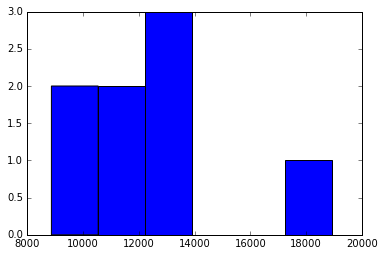

In [60]:
plt.hist( mouton_1982[ 'UnitPriceUSD'], 6 )
plt.show()

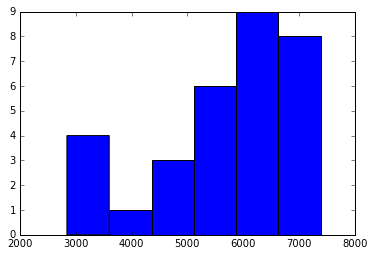

In [61]:
Vintage = "1999"
Producer = "Domaine de la Romanee Conti"
Wine = "La Tache"
producer_only = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains(Producer) ]
producer_wine = producer_only[ producer_only["Wine"].str.contains(Wine) ]

producer_wine_vintage = producer_wine[ producer_wine['Vintage'] == Vintage ]

plt.hist( producer_wine_vintage['UnitPriceUSD'], 6 )
plt.show()

In [62]:
producer_wine_vintage.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD
545,759,None,1185,"183 Apr 7, 2018 (NY)",6,6 bottles,,None,611,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,32240.0,1999,La Tache,32240.00,5373.333333
1094,521,None,1187,"183A Apr 21, 2018 (HK)",6,6 bottles,1x6 bottle banded owc,None,446,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,272800.0,1999,La Tache,34836.56,5806.093333
1149,578,None,1187,"183A Apr 21, 2018 (HK)",12,12 bottles,1nl 1wol,None,501,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,272800.0,1999,La Tache,34836.56,2903.046667
1150,579,None,1187,"183A Apr 21, 2018 (HK)",6,6 bottles,1 different importer 1nl 3vlbsl 3wol,None,502,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,136400.0,1999,La Tache,17418.28,2903.046667
1624,587,None,1188,"184 May 16, 2018 (NY)",1,1 bottle,lscl lstl lwrl,None,289,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,5952.0,1999,La Tache,5952.00,5952.000000


In [63]:
bottle_profit = bottle_grouped[ bottle_grouped["max"] / 1.25 > bottle_grouped["min"] ]
bottle_profit = bottle_profit.reset_index()
bottle_profit['diff'] = bottle_profit['max'] / 1.25 - bottle_profit['min']
bottle_profit = bottle_profit[ bottle_profit["count"] > 10 ]
bottle_profit = bottle_profit.sort_values('diff', ascending = False)
bottle_profit

,index,Vintage,Wine,ProducerAndDesignation,min,mean,max,count,diff
4,2314,1999,Romanee Conti,Domaine de la Romanee Conti,10028.706667,18481.627333,23224.373333,24,8550.792000
2,2274,1999,La Tache,Domaine de la Romanee Conti,2841.666667,5658.579462,7389.573333,31,3069.992000
39,2195,1999,Chambertin,A. Rousseau,899.000000,2914.087885,4960.000000,13,3069.000000
42,1321,1990,Chambertin,A. Rousseau,3224.000000,4757.275897,7750.000000,13,2976.000000
66,2850,2002,Romanee Conti,Domaine de la Romanee Conti,12616.760000,15934.525697,19001.760000,11,2584.648000
23,1897,1996,La Tache,Domaine de la Romanee Conti,1900.176000,3809.081699,4712.000000,17,1869.424000
17,2308,1999,Richebourg,Domaine de la Romanee Conti,1583.480000,3090.456851,4133.333333,19,1723.186667
6,1424,1990,La Tache,Domaine de la Romanee Conti,5046.704000,6756.803725,8445.226667,23,1709.477333
50,257,1959,Chateau Latour,Chateau Latour,1261.676000,2235.981806,3705.000000,12,1702.324000
53,2801,2002,La Tache,Domaine de la Romanee Conti,3087.500000,4043.022417,5806.093333,12,1557.374667


In [64]:
bottle_profit.shape

(73, 9)

In [18]:
#TODO list!
#check auction scraping - all web and in person? looks like for 1 year lookback total
#PnL 
#Trend over time
#Expected inventory, distributions of profit? strategies? always buy < max?)
#Lot sizes makes difference?
#Ullage level?
#Label condition?
#mixed lots built from single bottles?